<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As we'll see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

Wall time: 3.01 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

Wall time: 8 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool
z.compute()

Wall time: 2.03 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [7]:
z

Delayed('add-24040876-5f34-497f-85f8-27818b0d928c')

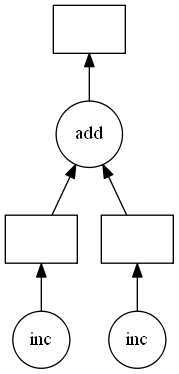

In [8]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

Another example:

In [9]:
import numpy as np
array = np.random.randn(1000)
array[0:10]

array([-0.19534153,  0.79788223,  1.33262526,  0.16035269,  1.60360272,
       -0.42222751, -0.18215753, -0.56498068,  1.12728556,  0.08057457])

In [10]:
%%time
def square(array):
    sleep(1)
    return array**2

def double(array):
    sleep(1)
    return 2*array

def divide(array):
    sleep(1)
    return array/3

def substract(array):
    sleep(1)
    return array-array/2

def add(a,b,c,d):
    sleep(1)
    return np.sum(a+b+c+d)

a = square(array)
b = double(array)
c = divide(array)
d = substract(array)

total = add(a,b,c,d)
total

Wall time: 5.02 s


912.9758779657109

Now lets carry out with dask delayed function:

In [11]:
a = delayed(square)(array)
b = delayed(double)(array)
c = delayed(divide)(array)
d = delayed(substract)(array)

total = delayed(add)(a,b,c,d)
total

Delayed('add-11c586f4-42b0-4897-b798-b6897f605a73')

This above cell deosnot performs any task but constructs a task graph that looks like this:

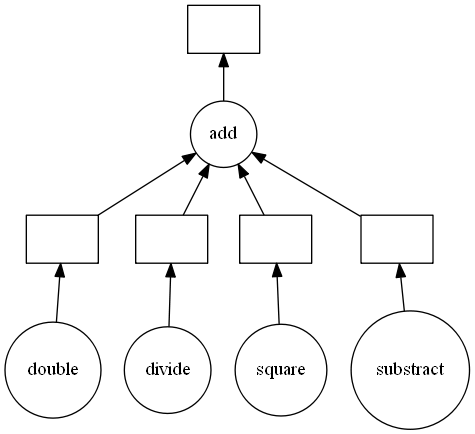

In [12]:
total.visualize()

Here the three functions will run simaltaneously in parallel giving a boost in the performance and eventually reduced calculation time:

In [13]:
%%time
total.compute()

Wall time: 2.04 s


912.9758779657109

Here the time taken has reduced from 5 seconds to 2 seconds

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s? 
- Because dask only parallelize the task that are independent of each other 

**That is because parallelisation is only possible for n independent processes.**

-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [14]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [15]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

Wall time: 8.04 s


In [16]:
total

44

In [17]:
%%time
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)

    
total = delayed(sum)(results)
print("before computing:", total)
result = total.compute()
print("After computing:",result)

before computing: Delayed('sum-4c4cbce4-5f5f-47e1-b44e-1d59c61172c4')
After computing: 44
Wall time: 1.03 s


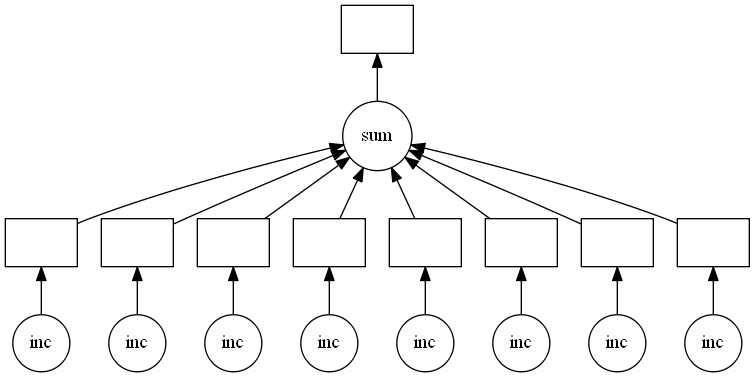

In [18]:
total.visualize()

In [19]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-42d885be-ff18-4e4d-a010-eaa2b046dc6c')
After computing : 44
Wall time: 1.03 s


How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

In [20]:
a = delayed(inc)(1) + delayed(inc)(2)
a

Delayed('add-0ea7e2a48b330b917a0beb6eb14c29a6')

In [21]:
%%time
a.compute()

Wall time: 1.02 s


5

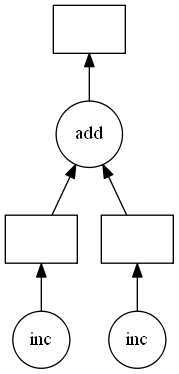

In [22]:
a.visualize()

Another example on loops:

In [23]:
%%time
x_data = np.arange(100)

def convert(x):
    '''converts tonne to KN'''
    sleep(0.1)
    return x*9.81


loads = []
for x in x_data:
    y = convert(x)
    loads.append(y)

total = sum(loads)
total

Wall time: 10.4 s


48559.5

Now lets try with dask.delayed functionality to parallelize the computation:

In [32]:
%%time
x_data = np.arange(100)

@delayed
def convert(x):
    '''converts tonne to KN'''
    sleep(0.1)
    return x*9.81


loads = []
for x in x_data:
    y = convert(x)
    loads.append(y)

total = delayed(sum)(loads)
total

Wall time: 0 ns


Delayed('sum-46d87126-71e7-4425-bd10-4d95d8f8961d')

The computation is not yet done but forms a task graph like this one below:

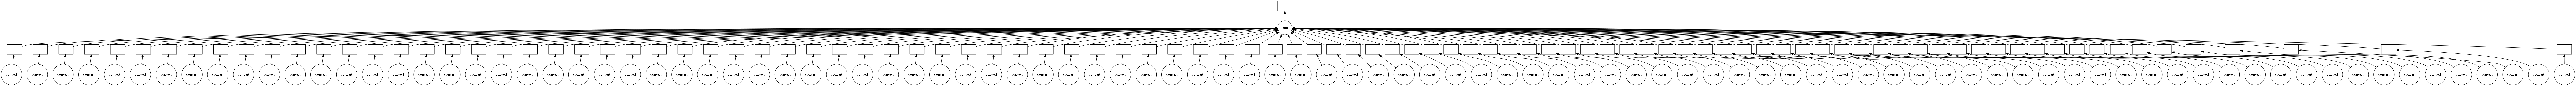

In [33]:
total.visualize()

In [34]:
%%time
total.compute()

Wall time: 1.03 s


48559.5

Earlier it was taking 10 seconds to complete the task, now with dask delayed parallel computing takes about only 2 secons which is a significant improvemnt in performace.

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [27]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [28]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
Wall time: 10 s


In [35]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total)

Delayed('sum-abe047eb-b18c-4191-9d8c-2d3da0085a0c')
Wall time: 2.95 ms


In [36]:
%%time
print(total.compute())

90
Wall time: 1.05 s


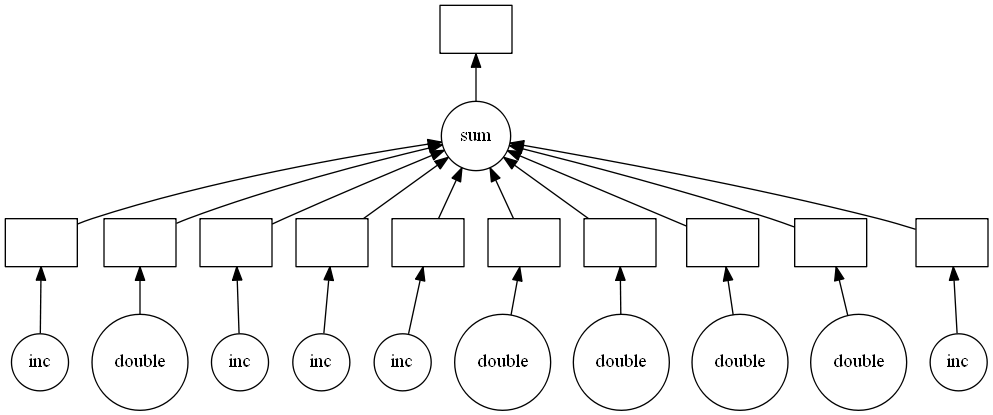

In [37]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

## Create data

Run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [38]:
import os
sorted(os.listdir(os.path.join("data","nycflights")))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [39]:
import pandas as pd

In [40]:
df = pd.read_csv(os.path.join("data","nycflights","1990.csv"))
print(df.shape)
df.head()

(271539, 23)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


### Inspect data

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271539 entries, 0 to 271538
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               271539 non-null  int64  
 1   Month              271539 non-null  int64  
 2   DayofMonth         271539 non-null  int64  
 3   DayOfWeek          271539 non-null  int64  
 4   DepTime            267645 non-null  float64
 5   CRSDepTime         271539 non-null  int64  
 6   ArrTime            266584 non-null  float64
 7   CRSArrTime         271539 non-null  int64  
 8   UniqueCarrier      271539 non-null  object 
 9   FlightNum          271539 non-null  int64  
 10  TailNum            0 non-null       float64
 11  ActualElapsedTime  266584 non-null  float64
 12  CRSElapsedTime     271539 non-null  int64  
 13  AirTime            0 non-null       float64
 14  ArrDelay           266584 non-null  float64
 15  DepDelay           267645 non-null  float64
 16  Or

In [43]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [44]:
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [46]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

Here we will calculate the average delay of all the files representing each year

In [48]:
from glob import glob
filenames = sorted(glob(os.path.join("data","nycflights","*.csv")))
filenames

['data\\nycflights\\1990.csv',
 'data\\nycflights\\1991.csv',
 'data\\nycflights\\1992.csv',
 'data\\nycflights\\1993.csv',
 'data\\nycflights\\1994.csv',
 'data\\nycflights\\1995.csv',
 'data\\nycflights\\1996.csv',
 'data\\nycflights\\1997.csv',
 'data\\nycflights\\1998.csv',
 'data\\nycflights\\1999.csv']

In [50]:
from tqdm import tqdm

In [51]:
%%time
sums = []
counts = []
# Read in file
for fname in tqdm(filenames, unit="csv_file"):
    df = pd.read_csv(fname)
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.35csv_file/s]

Wall time: 4.27 s


In [52]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  **Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.**

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  **Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:**

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [53]:
from dask import compute

In [59]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 4 ms


In [60]:
mean

Delayed('truediv-36d59a6b86a94d3dd5461368a04b318b')

In [62]:
%%time
compute(mean)

Wall time: 1.63 s


(Origin
 EWR    10.295469
 JFK    10.351299
 LGA     7.431142
 Name: DepDelay, dtype: float64,)

If you load the solution, add `%%time` to the top of the cell to measure the running time.

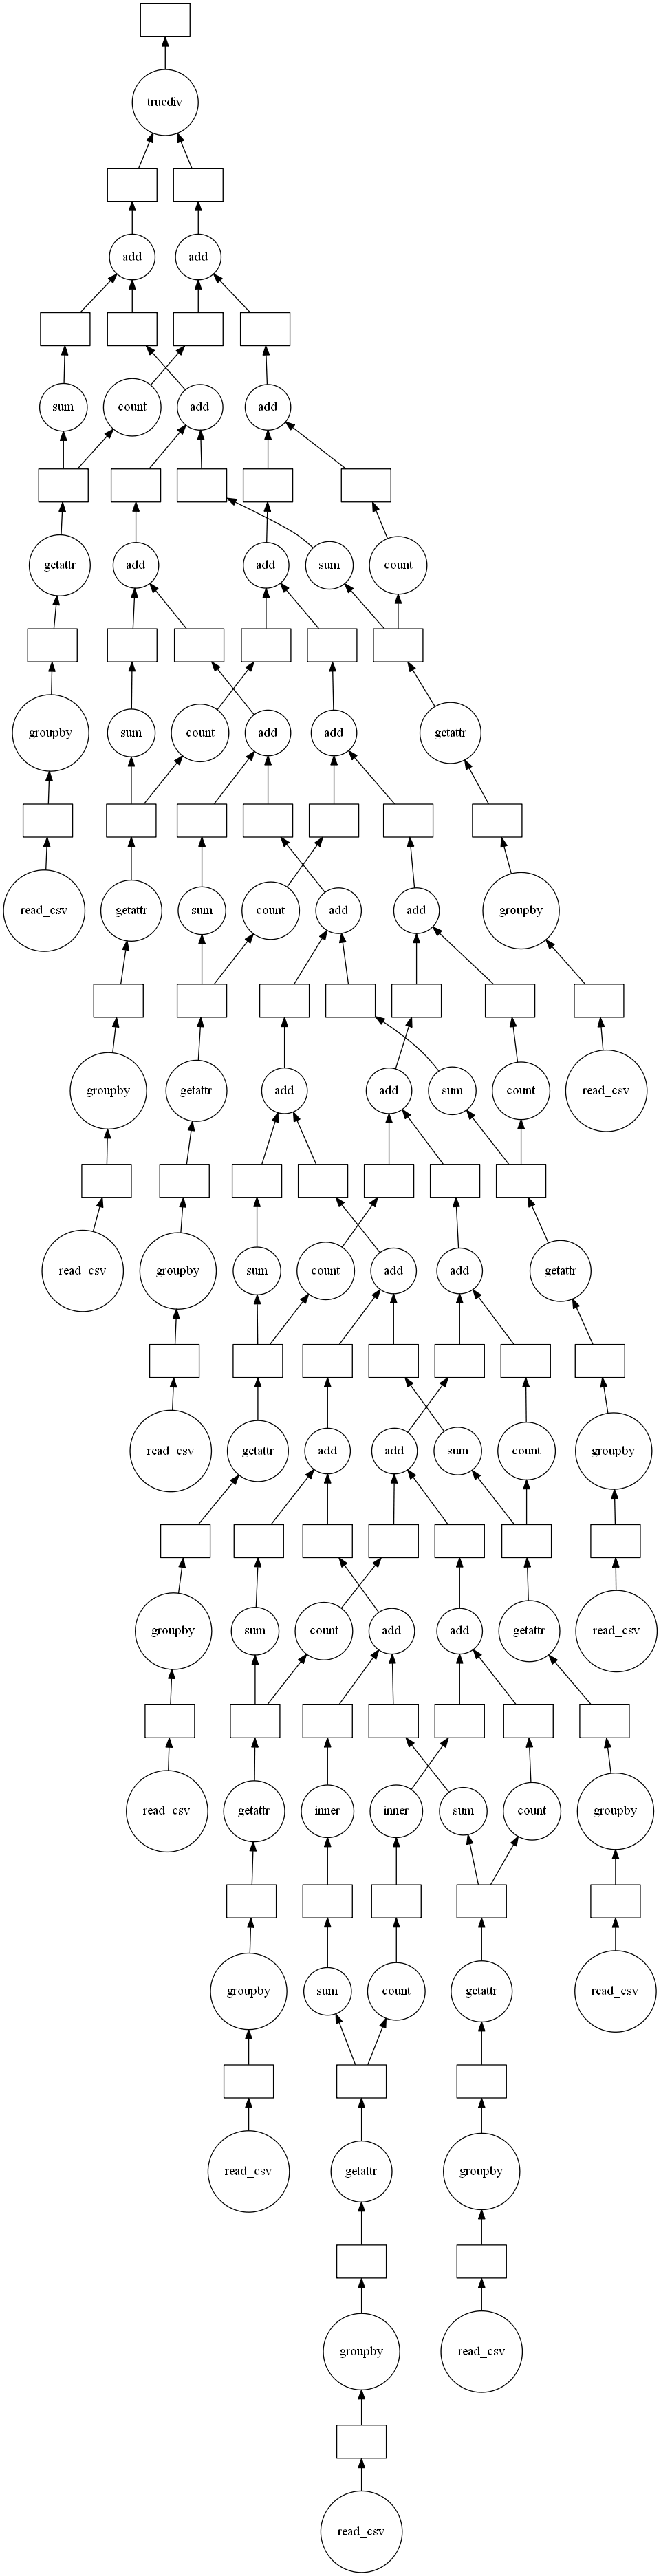

In [64]:
mean.visualize()

In [58]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Lets try another example based on the above dataset: 

find out the total average departure delays of each carrier

In [67]:
df = pd.read_csv(os.path.join("data","nycflights","1990.csv"))
print(df.shape)
df.head()

(271539, 23)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [68]:
df.UniqueCarrier.value_counts()

CO        64781
US        53149
AA        28869
PA (1)    25197
TW        24906
UA        20806
DL        20763
EA        16542
NW        13716
HP         2810
Name: UniqueCarrier, dtype: int64

In [84]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('UniqueCarrier')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 3.69 s


In [85]:
mean.sort_values(ascending=False).dropna()

UniqueCarrier
HP    15.902286
TW    11.210848
CO    10.454338
US     9.948441
DL     8.330365
NW     8.297315
UA     7.813786
AA     6.544586
Name: DepDelay, dtype: float64

The same task with dask delayed:

In [86]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('UniqueCarrier')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# compute the intermediates     
sums, counts = compute(sums,counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 1.88 s


In [87]:
mean.sort_values(ascending=False).dropna()

UniqueCarrier
HP    15.902286
TW    11.210848
CO    10.454338
US     9.948441
DL     8.330365
NW     8.297315
UA     7.813786
AA     6.544586
Name: DepDelay, dtype: float64

This is how the intermediate calculations look like: 

In [79]:
sums[0], counts[0]

(UniqueCarrier
 AA        207520.0
 CO        609512.0
 DL        206373.0
 EA        203921.0
 HP         52859.0
 NW        119240.0
 PA (1)    136066.0
 TW        327298.0
 UA        156221.0
 US        496870.0
 Name: DepDelay, dtype: float64,
 UniqueCarrier
 AA        28608
 CO        63637
 DL        20601
 EA        16425
 HP         2805
 NW        13442
 PA (1)    24958
 TW        24668
 UA        20319
 US        52182
 Name: DepDelay, dtype: int64)

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?

### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [63]:
client.close()